In [1]:
import syft as sy
sy.VERBOSE = False

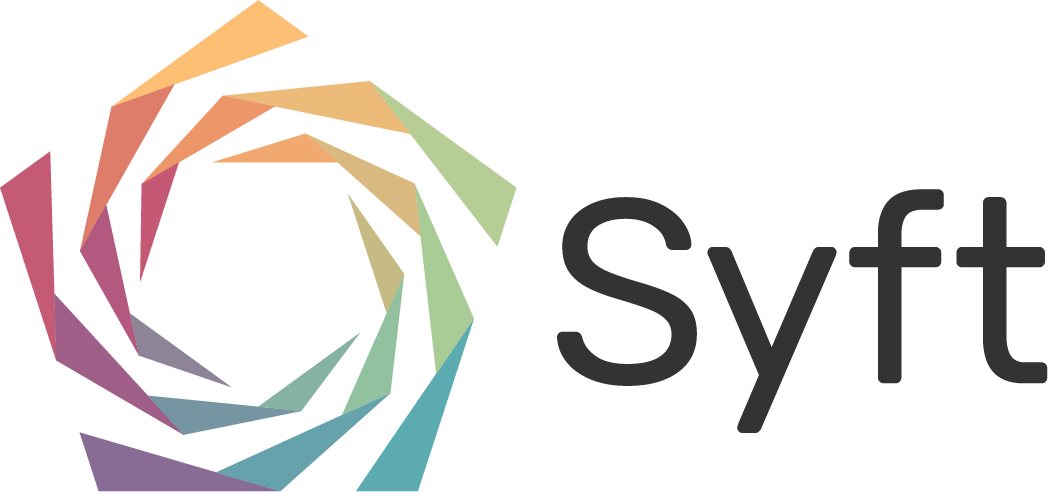

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ >             Use at your own risk.

♫♫♫ > 
♫♫♫ >
♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... DONE!

♫♫♫ > Duet Client ID: 513a124f8f0eaa3c4006dca290b81003

♫♫♫ > STEP 1: Send the Duet Client ID to your duet partner!

♫♫♫ > ...waiting for partner to connect...
♫♫♫ > ...using a running event loop...

♫♫♫ > CONNECTED!


In [2]:
duet = sy.join_duet(loopback=True)

In [6]:
duet.store.pandas

,ID,Tags,Description
0,<UID: 0377ca543cba4de5a39a21c0a0b0349e>,[schizophrenia-data],This is a dataset schizophrenia classification...
1,<UID: 19246c58cbba4efbb7d784b859e0620e>,[schizophrenia-target],"Class column. 0 = Healthy Control, 1 = Schizop..."


In [7]:
data_ptr = duet.store[0]
target_ptr = duet.store[1]

print(data_ptr)
print(target_ptr)

In [8]:
import torch

In [9]:
in_dim = 50
out_dim = 2
n_samples = 69

In [10]:
class SyNet(sy.Module):
    
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.layer1 = self.torch_ref.nn.Linear(in_dim, 20)
        self.layer2 = self.torch_ref.nn.Linear(20, 30)
        self.out = self.torch_ref.nn.Linear(30, out_dim)
        
    def forward(self, x):
        x = self.torch_ref.nn.functional.relu(self.layer1(x))
        x = self.torch_ref.nn.functional.relu(self.layer2(x))
        output = self.torch_ref.nn.functional.log_softmax(self.out(x), dim=1)
        return output
        
local_model = SyNet(torch)

> Creating local model


In [11]:
remote_model = local_model.send(duet)

> Sending local model
> Creating remote model
  Sending local layer: layer1
  Sending local layer: layer2
  Sending local layer: out

> Finished sending local model <




In [12]:
remote_torch = duet.torch

In [13]:
params = remote_model.parameters()
optim = remote_torch.optim.Adam(params=params, lr=0.01)

In [14]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):
    
    losses = []
    
    for i in range(iterations):
        
        optim.zero_grad()
        
        output = model(data_ptr)
        
        loss = torch_ref.nn.functional.nll_loss(output, target_ptr.long())
        
        loss_item = loss.item()
        
        loss_value = loss_item.get(
                name="loss",
                reason="To evaluate training progress",
                request_block=True,
                timeout_secs=5
            )
        
        if i % 10 == 0:
            print("Epoch", i, "loss", loss_value)
        
        losses.append(loss_value)
        
        loss.backward()
        
        optim.step()
        
    return losses

In [15]:
iteration = 20
losses = train(iteration, remote_model, remote_torch, optim, data_ptr, target_ptr)

Epoch 0 loss 4.255771160125732
Epoch 10 loss 0.010132593102753162


In [16]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'iteration')

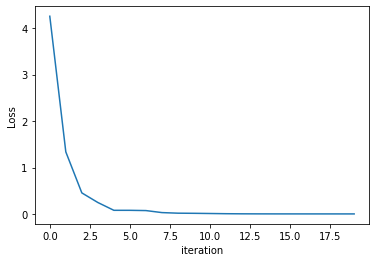

In [17]:
plt.plot(range(iteration), losses)
plt.ylabel('Loss')
plt.xlabel('iteration')

In [18]:
def get_local_model(model):
    if not model.is_local:
        local_model = model.get(
            request_block=True,
            name="model_download",
            reason="To run test and inference locally",
            timeout_secs=5,
        )
    else: 
        local_model = model
        
    return local_model

local_model = get_local_model(remote_model)

> Downloading remote model
> Creating local model

> Finished downloading remote model <




In [19]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [20]:
test_data = pd.read_csv('/Users/zarreennaowalreza/Desktop/openmined/PPMH/schrizofrenia_tab_data/final_test_50.csv')
print(test_data.shape)
test_data.head()

(17, 51)


,FNC40,FNC33,FNC20,SBM_map67,SBM_map61,SBM_map36,SBM_map17,FNC48,FNC37,FNC353,...,FNC289,FNC285,FNC278,FNC275,FNC23,FNC213,FNC211,FNC210,FNC177,Class
0,0.34404,0.64302,0.148900,-0.791032,0.829697,-0.026555,0.187573,0.515280,0.485810,0.273290,...,0.116160,0.11131,-0.14180,0.43596,0.40514,0.49545,0.62594,0.488840,0.15221,0
1,-0.12732,0.25707,0.373060,0.889753,-0.978412,-1.027496,1.961955,0.176950,-0.105510,-0.499290,...,0.110400,0.24471,0.16378,0.14387,-0.34615,0.43485,0.21171,-0.177450,0.19885,1
2,0.34123,0.66877,0.338740,0.785572,-0.896406,-0.213169,0.313224,0.253410,0.098053,-0.316810,...,-0.085182,-0.16643,0.26968,0.57360,-0.25904,0.61563,0.55868,0.447560,-0.36652,1
3,0.24601,0.59077,-0.067104,-1.522856,1.739382,1.574719,-1.308689,-0.033231,-0.304670,0.500520,...,0.078982,-0.51740,-0.57098,0.46945,0.19352,-0.22173,-0.10941,0.336160,-0.13141,0
4,-0.17317,0.51587,0.277670,-0.256770,0.263038,0.833339,-0.051214,0.679640,0.499420,0.083208,...,0.194680,0.21828,0.27271,0.37475,0.69264,0.36131,0.14574,0.027857,-0.11404,0


In [21]:
X_test = test_data.loc[:, test_data.columns != 'Class']
y_test = test_data['Class']

In [22]:
def laplaceMechanism(x, epsilon):
    x +=  np.random.laplace(0, 1.0/epsilon, 1)[0]
    return x

In [23]:
X_test_DP = pd.DataFrame()

epsilon = 0.012067926406393288
for col in X_test.columns:
    X_test_DP[col+'_DP'] = X_test[col].apply(laplaceMechanism, args=(epsilon,))
    
print(X_test_DP.shape)

(17, 50)


In [24]:
display(X_test.describe())
display(X_test_DP.describe())

,FNC40,FNC33,FNC20,SBM_map67,SBM_map61,SBM_map36,SBM_map17,FNC48,FNC37,FNC353,...,FNC30,FNC289,FNC285,FNC278,FNC275,FNC23,FNC213,FNC211,FNC210,FNC177
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,...,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.114289,0.413620,0.112796,-0.188294,0.249585,0.112180,-0.209129,0.266328,0.173247,-0.013812,...,0.392265,0.154915,-0.083712,-0.006125,0.192271,0.195068,0.233670,0.361138,0.282263,-0.094996
std,0.303886,0.228276,0.269331,0.876908,0.966511,1.106129,1.179037,0.310960,0.270683,0.253168,...,0.233634,0.147570,0.342046,0.333037,0.270504,0.351907,0.279376,0.282700,0.265420,0.259284
min,-0.532580,0.057134,-0.584940,-2.207213,-1.008680,-1.723418,-1.893651,-0.284800,-0.304670,-0.499290,...,0.045135,-0.223420,-0.517400,-0.570980,-0.429300,-0.428110,-0.310930,-0.259470,-0.179910,-0.379050
25%,-0.098532,0.257070,-0.027869,-0.791032,-0.723728,-0.844142,-1.190472,0.032942,-0.041024,-0.165820,...,0.169270,0.107450,-0.395820,-0.215260,-0.002636,0.033090,0.127890,0.162800,0.077043,-0.290960
50%,0.163750,0.336210,0.148900,-0.097483,0.263038,-0.026555,-0.343106,0.253410,0.101380,-0.014358,...,0.396220,0.165820,-0.166430,-0.129650,0.260690,0.199800,0.312960,0.426950,0.336160,-0.164130
75%,0.341230,0.589230,0.321630,0.434726,1.205206,0.890747,0.421326,0.515980,0.441560,0.158900,...,0.547500,0.273120,0.122610,0.269680,0.374750,0.406650,0.434850,0.558680,0.488840,0.048126
max,0.614960,0.877580,0.439020,0.889753,1.739382,1.700990,1.961955,0.745920,0.531660,0.500520,...,0.832510,0.329950,0.758320,0.751700,0.573600,0.692640,0.615630,0.686490,0.702120,0.520740


,FNC40_DP,FNC33_DP,FNC20_DP,SBM_map67_DP,SBM_map61_DP,SBM_map36_DP,SBM_map17_DP,FNC48_DP,FNC37_DP,FNC353_DP,...,FNC30_DP,FNC289_DP,FNC285_DP,FNC278_DP,FNC275_DP,FNC23_DP,FNC213_DP,FNC211_DP,FNC210_DP,FNC177_DP
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,...,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,-45.426062,18.614623,-38.791500,-43.574768,15.099785,-2.939196,-32.331423,-39.625071,-1.331233,12.222392,...,-6.777427,-21.534343,25.269369,-18.197591,-20.580496,-15.876877,-2.436333,18.965650,-24.961983,-30.794959
std,100.329944,156.097438,154.789368,111.506493,141.345163,123.601153,77.781598,171.697311,176.998685,138.231855,...,142.734690,65.092581,102.656215,107.771078,178.939374,141.836632,175.203693,83.756048,79.777473,82.168688
min,-256.869568,-148.970285,-369.940050,-263.839995,-374.279917,-309.611112,-185.341754,-533.887786,-408.938887,-156.240132,...,-243.802716,-196.207349,-133.222073,-298.216950,-438.591165,-356.369707,-517.988128,-142.135271,-214.141833,-280.493661
25%,-55.012235,-87.440441,-102.248950,-93.894646,-47.215921,-60.607399,-67.489688,-94.147616,-27.220299,-116.152902,...,-59.551080,-61.161952,-14.516821,-70.564075,-56.964157,-67.293064,-60.011756,-35.032128,-70.107909,-66.012340
50%,-14.539824,-31.379643,-48.146772,-6.649190,26.278810,-25.707170,-28.479539,11.262662,11.503514,9.759350,...,-16.130500,-7.550376,-2.898917,-5.114853,-20.802654,-8.347519,-5.733198,1.932652,-4.297309,-32.893782
75%,8.303360,98.866706,25.935501,22.602176,92.461444,46.496296,14.123280,59.623789,51.789543,90.388110,...,40.322106,5.027736,61.492102,40.230027,78.976312,37.134119,108.253491,61.957077,26.229386,19.879232
max,138.589698,415.166551,258.938212,149.299631,235.690983,235.654901,132.414250,141.101671,399.240527,260.670806,...,343.738906,100.223925,281.667337,137.106931,237.230435,290.660030,291.417120,160.307037,103.333460,82.275953


In [25]:
X_test_DP = torch.FloatTensor(np.array(X_test_DP))
y_test_DP = torch.LongTensor(np.array(y_test))

In [26]:
preds = []
with torch.no_grad():
    for i in range(len(X_test_DP)):
        sample = X_test_DP[i]
        y_hat = local_model(sample.unsqueeze(0))
        pred = y_hat.argmax().item()
        print(f"Prediction: {pred} Ground Truth: {y_test_DP[i]}")
        preds.append(pred)

Prediction: 0 Ground Truth: 0
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 1
Prediction: 1 Ground Truth: 0
Prediction: 1 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 1 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 1
Prediction: 1 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 1 Ground Truth: 0
Prediction: 0 Ground Truth: 0


In [27]:
acc = accuracy_score(y_test_DP, preds)
print("Overall test accuracy", acc*100)

Overall test accuracy 58.82352941176471
